In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from diffrax import Dopri5, Dopri8, Tsit5

from sepsis_osc.dnm.dynamic_network_model import DNMConfig, DNMMetrics, DNMState, DynamicNetworkModel
from sepsis_osc.ldm.lookup import LatentLookup, as_2d_indices
from sepsis_osc.storage.storage_interface import Storage
from sepsis_osc.utils.config import plt_params
from sepsis_osc.utils.jax_config import setup_jax
from sepsis_osc.visualisations.viz_ensemble_run import plot_metric_t
from sepsis_osc.visualisations.viz_param_space import pretty_plot, space_plot
from sepsis_osc.visualisations.viz_single_run import plot_kappa, plot_phase_snapshot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
setup_jax(simulation=True)

In [2]:
from sepsis_osc.utils.config import plt_params
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt_params = {
    "figure.figsize": (10, 4),  # inches
    "font.size": SMALL_SIZE,
    "axes.titlesize": BIGGER_SIZE,
    "axes.labelsize": MEDIUM_SIZE,
    "xtick.labelsize": SMALL_SIZE,
    "ytick.labelsize": SMALL_SIZE,
    "legend.fontsize": SMALL_SIZE,
    "figure.dpi": 100,
}

plt.rcParams.update(plt_params)


In [3]:
ALPHA = -0.28
BETA_SPACE = (0.0, 1.0, 0.01)  # only original area
SIGMA_SPACE = (0.0, 1.5, 0.015)  # only original area
db_str = "Daisy2"
sim_storage = Storage(
    key_dim=9,
    metrics_kv_name=f"../data/{db_str}SepsisMetrics.db/",
    parameter_k_name=f"../data/{db_str}SepsisParameters_index.bin",
    use_mem_cache=True,
)
sim_storage.close()

b, r = as_2d_indices(BETA_SPACE, SIGMA_SPACE)
a = np.ones_like(b) * ALPHA
indices_3d = jnp.concatenate([a[..., np.newaxis], b[..., np.newaxis], r[..., np.newaxis]], axis=-1)[np.newaxis, ...]

spacing_3d = jnp.array([0.0, BETA_SPACE[2], SIGMA_SPACE[2]])
params = DNMConfig.batch_as_index(a, b, r, 0.2)
metrics_3d, _ = sim_storage.read_multiple_results(params, proto_metric=DNMMetrics, threshold=0.0)
metrics_3d = metrics_3d.to_jax().reshape([1, *metrics_3d.shape["r_1"]])

metrics_2d = metrics_3d.squeeze()

T_init, T_max = 0, 2000
T_step = 0.01

2026-02-01 15:57:17 - sepsis_osc.storage.storage_interface - INFO     - Got ../data/Daisy2SepsisParameters_index.bin and ../data/Daisy2SepsisMetrics.db/
2026-02-01 15:57:17 - sepsis_osc.storage.storage_interface - INFO     - FAISS index ../data/Daisy2SepsisParameters_index.bin loaded from disk.
2026-02-01 15:57:17 - sepsis_osc.storage.storage_interface - INFO     - Preloading memory cache from RocksDB...
2026-02-01 15:57:18 - sepsis_osc.storage.storage_interface - INFO     - Successfully loaded 70000 metrics into memory.
2026-02-01 15:57:18 - sepsis_osc.utils.utils         - INFO     - func:'__setup_memory_cache' took: 1.827174 sec
2026-02-01 15:57:19 - sepsis_osc.storage.storage_interface - INFO     - Getting Metrics for multiple queries with shape (100, 100, 9)
2026-02-01 15:57:19 - sepsis_osc.storage.storage_interface - INFO     - Searching 10000 keys in FAISS index
2026-02-01 15:57:19 - sepsis_osc.storage.storage_interface - INFO     - Found vectors with distance 0.0, index (20000,

# Phase Space

In [8]:
def plot_phase() -> plt.Figure:
    xs = np.arange(*BETA_SPACE)
    ys = np.arange(*SIGMA_SPACE)

    orig_xs = np.asarray([np.argmin(np.abs(xs - x)) for x in [0.4, 0.7]])
    orig_ys = np.asarray([len(ys) - np.argmin(np.abs(ys - y)) - 1 for y in [0.0, 1.5]])
    fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, squeeze=True)
    pretty_plot(
        metrics_2d.s_1, metrics_2d.s_2, r"$s$", xs=xs, ys=ys, orig_xs=orig_xs, orig_ys=orig_ys, figax=(fig, axes[0]),
        x_label=False
    )

    configs = {"A": (0.5, 1.0), "B": (0.58, 1.0), "C": (0.7, 1.0), "D": (0.5, 0.7)}
    pretty_plot(
        metrics_2d.r_1, metrics_2d.r_2, r"$R$", xs=xs, ys=ys, orig_xs=orig_xs, orig_ys=orig_ys, figax=(fig, axes[1])
    )
    for n, c in configs.items():
        b, s = c
        beta_scale = len(xs) * (b - BETA_SPACE[0]) / (BETA_SPACE[1] - BETA_SPACE[0])
        sigma_scale = len(ys) * (1 - (s - SIGMA_SPACE[0]) / (SIGMA_SPACE[1] - SIGMA_SPACE[0]))
        for i in range(2):
            for j in range(2):
                axes[i, j].scatter(beta_scale, sigma_scale, c="tab:orange")
                axes[i, j].annotate(n, (beta_scale + 2, sigma_scale + 1), c="tab:orange")
    

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    return fig

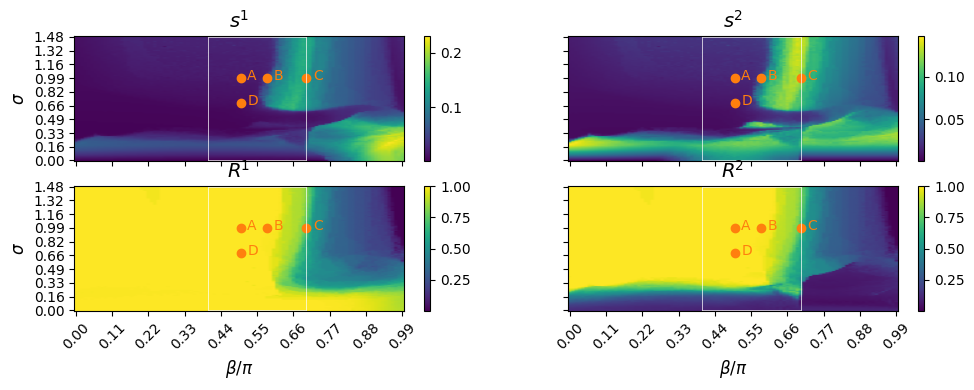

In [9]:
phase_fig = plot_phase()

In [10]:
phase_fig.savefig("../typst/images/phase.svg")
phase_fig.savefig("../typst/images/paper/phase.png", dpi=400)

# Snapshots

In [11]:
N = 200
A = DNMConfig(  # A
        N=N,
        C=0.2,  # local infection
        omega_1=0.0,
        omega_2=0.0,
        a_1=1.0,
        epsilon_1=0.03,  # adaption rate
        epsilon_2=0.3,  # adaption rate
        alpha=-0.28,  # phase lage
        beta=0.5,  # age parameter
        sigma=1.0,
    )
B = DNMConfig(  # B
        N=N,
        C=0.2,
        omega_1=0.0,
        omega_2=0.0,
        a_1=1.0,
        epsilon_1=0.03,
        epsilon_2=0.3,
        alpha=-0.28,
        beta=0.58,
        sigma=1.0,
    )
C = DNMConfig(  # C
        N=N,
        C=0.2,
        omega_1=0.0,
        omega_2=0.0,
        a_1=1.0,
        epsilon_1=0.03,
        epsilon_2=0.3,
        alpha=-0.28,
        beta=0.7,
        sigma=1.0,
    )
D = DNMConfig(  # D
        N=N,
        C=0.2,
        omega_1=0.0,
        omega_2=0.0,
        a_1=1.0,
        epsilon_1=0.03,
        epsilon_2=0.3,
        alpha=-0.28,
        beta=0.5,
        sigma=0.2,
    )

In [12]:
M = 1
rand_keys = [jr.key(2), jr.key(24), jr.key(42), jr.key(2), jr.key(356),]
run_confs = [ A, B, C, C, D ]

dnm = DynamicNetworkModel(full_save=True, steady_state_check=False, progress_bar=True, full_save_dtype=jnp.float64)

#run_conf = DNMConfig(  # B
#    N=N,
#    C=0.2,
#    omega_1=0.0,
#    omega_2=0.0,
#    a_1=1.0,
#    epsilon_1=0.03,
#    epsilon_2=0.3,
#    alpha=-0.28,
#    beta=0.58,
#    sigma=1.0,
#)

# dnm = DynamicNetworkModel(full_save=False, steady_state_check=False, progress_bar=False, full_save_dtype=jnp.float64)
# best_i = 0
# best_r = float("inf")
# for i in range(339, 1000):
#     sol = dnm.integrate(config=run_conf, M=M, key=jr.key(i), T_init=T_init, T_max=T_max, T_step=T_step, solver=Dopri8())
#     r = sol.ys.s_1[-1]
#     if r < best_r:
#         best_r = r
#         best_i = i
#     print(i, best_i, best_r)

sols = [
    dnm.integrate(config=run_conf, M=M, key=rand_key, T_init=T_init, T_max=T_max, T_step=T_step, solver=Dopri5())
    for rand_key, run_conf in zip(rand_keys, run_confs, strict=True)
]

sol = sols[0]
ys, dys = sol.ys
ys, dys = ys.remove_infs().squeeze().enforce_bounds(), dys.remove_infs().squeeze()
sorting1 = np.lexsort((dys.phi_1.mean(axis=0), ys.phi_1[-1]))
sorting2 = np.lexsort((dys.phi_2.mean(axis=0), ys.phi_2[-1]))


 ... (more hidden) ...
2026-02-01 15:58:22 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 6.885425 sec
 ... (more hidden) ...
2026-02-01 15:58:24 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 2.147400 sec
 ... (more hidden) ...
2026-02-01 15:58:27 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 2.941330 sec
 ... (more hidden) ...
2026-02-01 15:58:29 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 1.463516 sec
 ... (more hidden) ...
2026-02-01 15:58:30 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 1.811562 sec


In [13]:
def plot_snapshots() -> None:
    fig = plt.figure()

    gs_left = GridSpec(
        len(sols), 3,
        width_ratios=[.5, 1, 1],
        wspace=0.2,
        hspace=0.3
    )

    gs_right = GridSpec(
        len(sols), 2,
        width_ratios=[1, 1],
        wspace=0.2,
        hspace=0.3
    )

    gs_last = GridSpec(
        len(sols), 1,
        width_ratios=[0.5],
        wspace=0.2,
        hspace=0.3
    )
    
    # Create colorbar axes on top of first row
    gs_cbar_left = GridSpec(1, 1, wspace=0.2, hspace=0.3)
    gs_cbar_right = GridSpec(1, 1, wspace=0.2, hspace=0.3)

    for i, sol in enumerate(sols):
        cbar = i == 0
        ys, dys = sol.ys
        ys, dys = ys.remove_infs().squeeze().enforce_bounds(), dys.remove_infs().squeeze()
        sorting1 = np.lexsort((dys.phi_1.mean(axis=0), ys.phi_1[-1]))
        sorting2 = np.lexsort((dys.phi_2.mean(axis=0), ys.phi_2[-1]))

        ax0 = fig.add_subplot(gs_left[i, 0])
        ax1 = fig.add_subplot(gs_left[i, 1])
        ax2 = fig.add_subplot(gs_left[i, 2])
        ax3 = fig.add_subplot(gs_right[i, 0])
        ax4 = fig.add_subplot(gs_right[i, 1])
        ax5 = fig.add_subplot(gs_last[i, 0])
        
        # Create colorbar axes for first row
        if i == 0:
            cax0 = fig.add_subplot(gs_cbar_left[0, 0])
            cax5 = fig.add_subplot(gs_cbar_right[0, 0])
        else:
            cax0 = None
            cax5 = None

        axs = (ax0, ax1, ax2, ax3, ax4, ax5)
        
        plot_kappa(
            np.asarray(ys.kappa_1),
            np.asarray(ys.kappa_2),
            sorting_1=sorting1,
            sorting_2=sorting2,
            t=-1,
            figax=(fig, [ax0, ax5]),
            cax=[cax0, cax5] if cbar else [None, None],
            cbar1=cbar, cbar2=cbar, cbar_loc="top"
        )
        plot_phase_snapshot(
            np.asarray(dys.phi_1),
            np.asarray(dys.phi_2),
            t=-1,
            deriv=True,
            ax=[ax1, ax2],
        )
        plot_phase_snapshot(
            np.asarray(ys.phi_1),
            np.asarray(ys.phi_2),
            t=-1,
            deriv=False,
            ax=[ax3, ax4],
        )
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax4.set_yticks([])
        ax4.set_yticklabels([])
        ax0.text(-1.9, 0.7, ('A', 'B', 'C', "C'", 'D')[i], 
                 transform=ax0.transAxes, fontsize=14, fontweight='bold', va='top')
        ax0.set_ylabel("Index j")
        ax5.set_ylabel("Index j")
        ax5.yaxis.set_label_position("right")
        ax5.yaxis.tick_right()
        if i != len(sols) - 1:
            for ax in axs:
                ax.set_xticks([])
                ax.set_xticklabels([])
        else:
            ax0.set_xlabel("Index i")
            ax1.set_xlabel("Index i")
            ax2.set_xlabel("Index i")
            ax3.set_xlabel("Index i")
            ax4.set_xlabel("Index i")
            ax5.set_xlabel("Index i")
        pos = axs[2].get_position()
        axs[2].set_position([pos.x0 - 0.015, pos.y0, pos.width, pos.height])
        pos = axs[4].get_position()
        axs[4].set_position([pos.x0 - 0.015, pos.y0, pos.width, pos.height])
        if i == 0:
            axs[0].set_title(r"$\kappa_{ij}^1$", y=1.2, x=-0.8)
            axs[1].set_title(r"$\dot{\phi_i}^{1}$")
            axs[2].set_title(r"$\dot{\phi_i}^{2}$")
            axs[3].set_title(r"$\phi_i^{1}$ / $\pi$")
            axs[4].set_title(r"$\phi_i^{2}$ / $\pi$")
            axs[5].set_title(r"$\kappa_{ij}^2$", y=1.2, x=-0.8)
            
            # Position colorbar axes on top of ax0 and ax5
            pos0 = ax0.get_position()
            pos5 = ax5.get_position()
            cbar_height = 0.02
            cbar_pad = 0.01
            cax0.set_position([pos0.x0, pos0.y1 + cbar_pad, pos0.width, cbar_height])
            cax5.set_position([pos5.x0, pos5.y1 + cbar_pad, pos5.width, cbar_height])

    gs_left.update(right=0.525)
    gs_right.update(left=0.575)
    gs_last.update(right=1.77)
    gs_cbar_left.update(left=0.13, right=0.19, bottom=0.89, top=0.91)
    gs_cbar_right.update(left=0.915, right=0.98, bottom=0.89, top=0.91)
    return fig



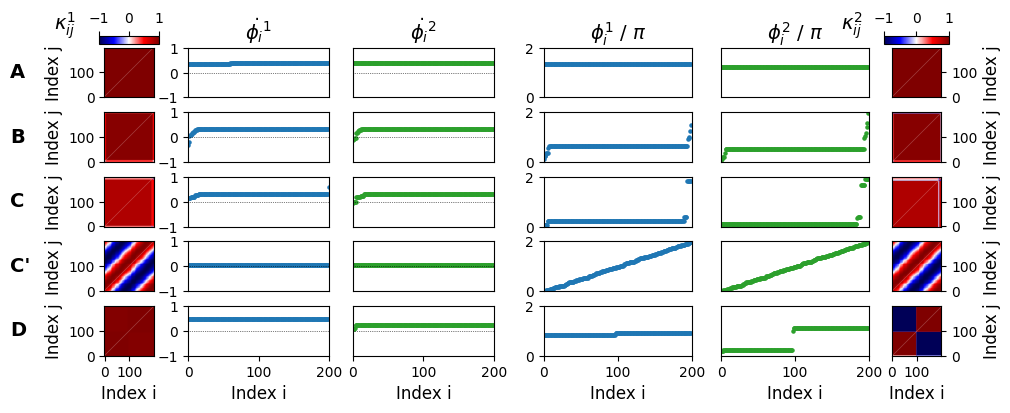

In [14]:
snap_fig = plot_snapshots()
plt.show()

In [15]:
snap_fig.savefig("../typst/images/snapshots.svg")
snap_fig.savefig("../typst/images/paper/snapshots.png", dpi=400)

# Initial Conditions

In [12]:
def plot_init():
    x, y  = plt_params["figure.figsize"]
    print(x, y)
    fig = plt.figure(figsize=(x, y/1.5))
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0.25)    
    ax0, ax1, ax2, ax3 = fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])    
    plot_kappa(
        np.asarray(ys.kappa_1),
        np.asarray(ys.kappa_2),
        sorting_1=sorting1,
        sorting_2=sorting2,
        t=0,
        figax=(fig, [ax0, ax3]),
        cbar1=True, cbar2=True, cbar_loc="inside"
    )
    plot_phase_snapshot(np.asarray(ys.phi_1), np.asarray(ys.phi_2), t=0, deriv=False, ax=[ax1, ax2])
    ax0.set_title(r"$\kappa_{ij}^1$")
    ax0.set_xlabel("Index i")
    ax0.set_ylabel("Index j")

    ax1.set_xlabel("Index i")
    ax1.set_title(r"$\phi_i^{1}$ / $\pi$")

    ax2.set_xlabel("Index i")
    ax2.set_title(r"$\phi_i^{2}$ / $\pi$")

    ax3.set_title(r"$\kappa_{ij}^2$")
    ax3.set_xlabel("Index i")
    ax3.set_ylabel("Index j")
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()

    ax1.set_aspect(100, adjustable='box')
    ax2.set_aspect(100, adjustable='box')
    fig.subplots_adjust(top=1.3, bottom=-0.2, hspace=0, left=0.075, right=0.925) 
    return fig

10 4


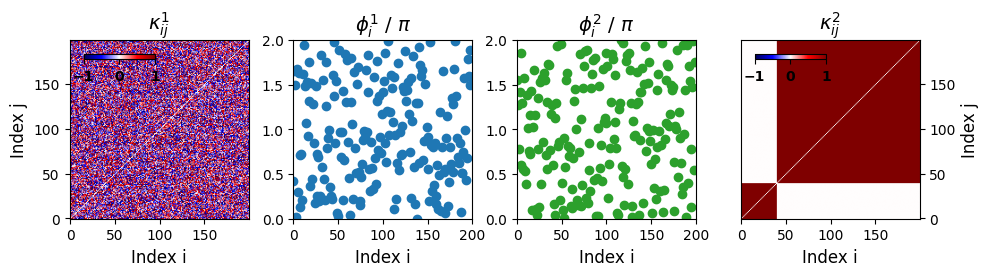

In [13]:
init_fig = plot_init()
plt.show()

In [14]:
init_fig.savefig("../typst/images/init.svg")
init_fig.savefig("../typst/images/paper/init.png", dpi=400)

# Ensembles

In [16]:
N = 200
M = 50
run_confs = [A, B, C, D]
step_size = 10
dnm = DynamicNetworkModel(full_save=False, steady_state_check=False, progress_bar=True)
ensemble_sols = [
    dnm.integrate(
        config=run_conf,
        M=M,
        key=jr.key(0),
        T_init=T_init,
        T_max=T_max,
        T_step=T_step,
        solver=Tsit5(),
        ts=jnp.arange(T_init, T_max, step_size),
    )
    for run_conf in run_confs
]

 ... (more hidden) ...
2026-02-01 17:05:30 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 70.371060 sec
 ... (more hidden) ...
2026-02-01 17:07:37 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 127.205055 sec
 ... (more hidden) ...
2026-02-01 17:09:03 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 85.983189 sec
 ... (more hidden) ...
2026-02-01 17:09:55 - sepsis_osc.utils.utils         - INFO     - func:'integrate' took: 51.912888 sec


In [20]:
def plot_ensembles() -> None:
    fig, axs = plt.subplots(len(ensemble_sols), 4)

    ysmax = 0.0
    yrmax = 0.0
    for i, sol in enumerate(ensemble_sols):
        ysmax = max(sol.ys.s_1.max(), sol.ys.s_2.max(), ysmax)
        yrmax = max(sol.ys.r_1.max(), sol.ys.r_2.max(), yrmax)
        ax0, ax1, ax2, ax3 = axs[i]
        plot_metric_t(sol.ys.r_1, sol.ys.r_2, step_size=step_size, ax=[ax0, ax1], a=0.5)
        plot_metric_t(sol.ys.s_1, sol.ys.s_2, step_size=step_size, ax=[ax2, ax3], a=0.5)
        
        t = np.arange(sol.ys.r_1.shape[0]) * 10
        ax0.plot((0, 0), (0, 0), label="Single Ensemble Member", color="tab:blue", rasterized=True)
        ax0.plot(t, sol.ys.r_1.mean(axis=-1), c="tab:orange", label="Ensemble Mean")
        ax0.text(-0.3, 0.7, f"{('A', 'B', 'C', 'D')[i]}",
                 transform=ax0.transAxes, fontsize=14, fontweight='bold', va='top')
        ax1.plot(t, sol.ys.r_2.mean(axis=-1), c="tab:orange")
        ax2.plot(t, sol.ys.s_1.mean(axis=-1), c="tab:orange")
        ax3.plot(t, sol.ys.s_2.mean(axis=-1), c="tab:orange")
        if i != len(ensemble_sols) - 1:
            for ax in axs[i]:
                ax.set_xticks([])  # removes tick marks
                ax.set_xticklabels([])
        else:
            ax0.set_xlabel("t")
            ax1.set_xlabel("t")
            ax2.set_xlabel("t")
            ax3.set_xlabel("t")
    for i in range(len(ensemble_sols)):
        ax0, ax1, ax2, ax3 = axs[i]
        ax0.set_ylim(0, yrmax * 1.05)
        ax1.set_ylim(0, yrmax * 1.05)
        ax2.set_ylim(0, ysmax * 1.05)
        ax3.set_ylim(0, ysmax * 1.05)
    axs[0, 0].set_title(r"$R^1$")
    axs[0, 1].set_title(r"$R^2$")
    axs[0, 2].set_title(r"$s^1$")
    axs[0, 3].set_title(r"$s^2$")
    axs[0, 0].legend(ncols=2, bbox_to_anchor=(4, 1.9), frameon=False)
    
    fig.subplots_adjust(wspace=0.4)
    return fig

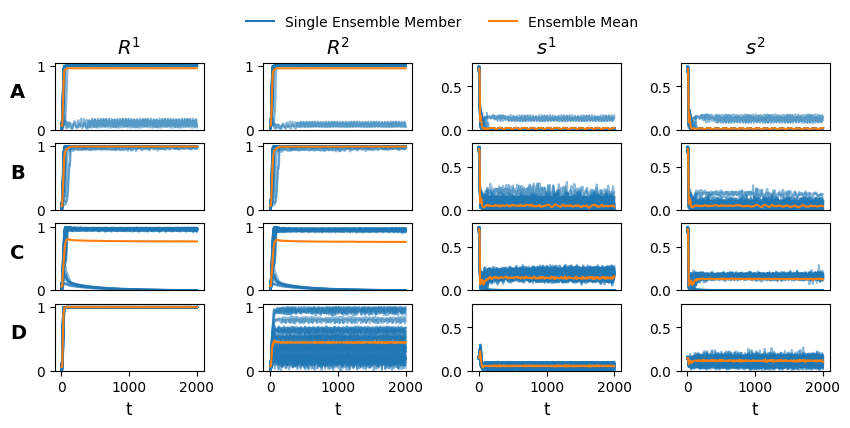

In [21]:
ensemble_fig = plot_ensembles()

In [22]:
ensemble_fig.savefig("../typst/images/ensembles.svg")
ensemble_fig.savefig("../typst/images/paper/ensembles.png", dpi=400)